In [1]:
import os
import pickle
from dassl.data.datasets import Datum
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

(0.0, 10.0)

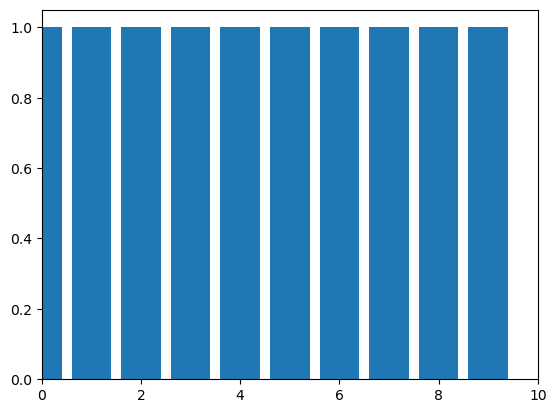

In [5]:
path = "/data2/yhiro/data/eurosat_active/split_fewshot"
with open(os.path.join(path, "shot_1-seed_1-active.pkl"), "rb") as file:
    shot1= pickle.load(file)


active_label = [d.label for d in shot1]

count = Counter(active_label)

height = []
for i in range(len(active_label)):
    if i not in count.keys():
        height.append(0)
    else:
        height.append(count[i])
plt.bar(range(len(height)), height)
plt.xlim(0,10)
#plt.ylim(0,8.2)
#[print(d.label) for d in shot1]
#print("--------")
#[print(d.label) for d in shot2["train"]]

/home/yhiro/miniconda3/envs/dassl2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


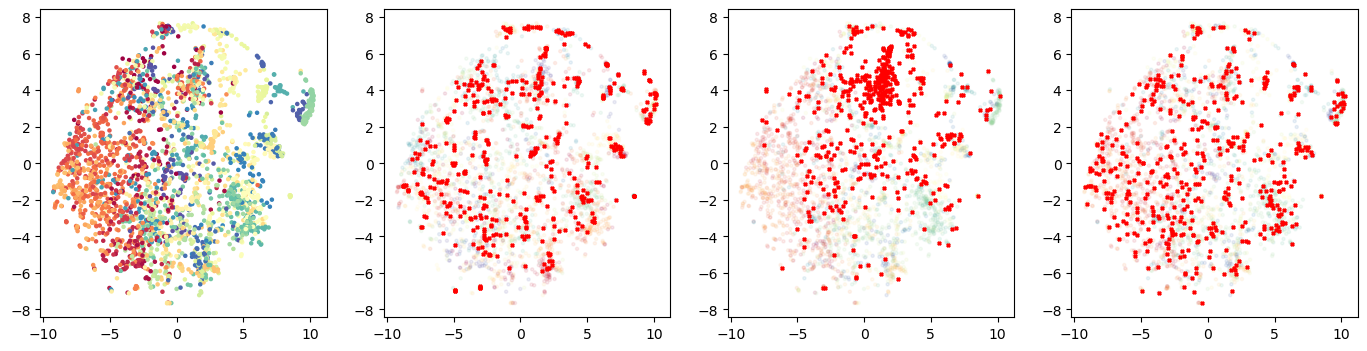

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(17,4))
ax.ravel()

filepath = "output/ActiveLearning/vit_b16"
dname = "fgvc_aircraft"
K = 100
sample_size_by_category = 5

with open(os.path.join(filepath, dname, "img_features.pkl"), "rb") as file:
    img_features = pickle.load(file)
    img_features = np.array(img_features)

preds = np.load(os.path.join(filepath, dname, "preds.npy"))
labels = np.load(os.path.join(filepath, dname, "labels.npy"))
entropies = np.load(os.path.join(filepath, dname, "entropy.npy"))

sample_size = 3000  # Define the number of points to sample
indices = np.random.choice(img_features.shape[0], sample_size, replace=False)
img_features = img_features[indices]
labels = labels[indices]
preds = preds[indices]
entropies = entropies[indices]

# 画像特徴量をクラスタリング
kmeans = KMeans(n_clusters=K, random_state=42)
img_features = np.array(img_features)
kmeans.fit(img_features)
labels_kmeans = kmeans.labels_

# 重心から近い順にサンプリング
distances = pairwise_distances(kmeans.cluster_centers_, img_features)
sample_idx = []
for d in distances:
    d_minid = np.argsort(d)
    d_minid = d_minid[:sample_size_by_category]
    sample_idx.extend(d_minid)
sample_idx = np.array(list(set(sample_idx)))

# エントロピーの大きい順にソート
entropies_sort_idx = np.argsort(entropies)[::-1][:sample_size_by_category*K]


# エントロピー＋クラスター
entropies_ = entropies[sample_idx]
entropies_sort_idx_ = np.argsort(entropies_)[::-1]

# ランダム
random_idx = np.random.choice(img_features.shape[0], sample_size_by_category*K, replace=False)



tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embedding = tsne_model.fit_transform(img_features)

ax[0].scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', c=labels)
#ax[1].scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', c=labels_kmeans)

ax[1].scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', c=labels_kmeans, alpha=0.1)
ax[1].scatter(embedding[sample_idx, 0], embedding[sample_idx, 1], s=5, c="red" ,marker="X")

ax[2].scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', c=preds, alpha=0.1)
ax[2].scatter(embedding[entropies_sort_idx, 0], embedding[entropies_sort_idx, 1], s=5, c="red" ,marker="X")

ax[3].scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', c=preds, alpha=0.1)
ax[3].scatter(embedding[entropies_sort_idx_, 0], embedding[entropies_sort_idx_, 1], s=5, c="red" ,marker="X")

#ax[4].scatter(embedding[:, 0], embedding[:, 1], s=5, cmap='Spectral', c=preds, alpha=0.1)
#ax[4].scatter(embedding[random_idx, 0], embedding[random_idx, 1], s=5, c="red" ,marker="X")



/home/yhiro/miniconda3/envs/dassl2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


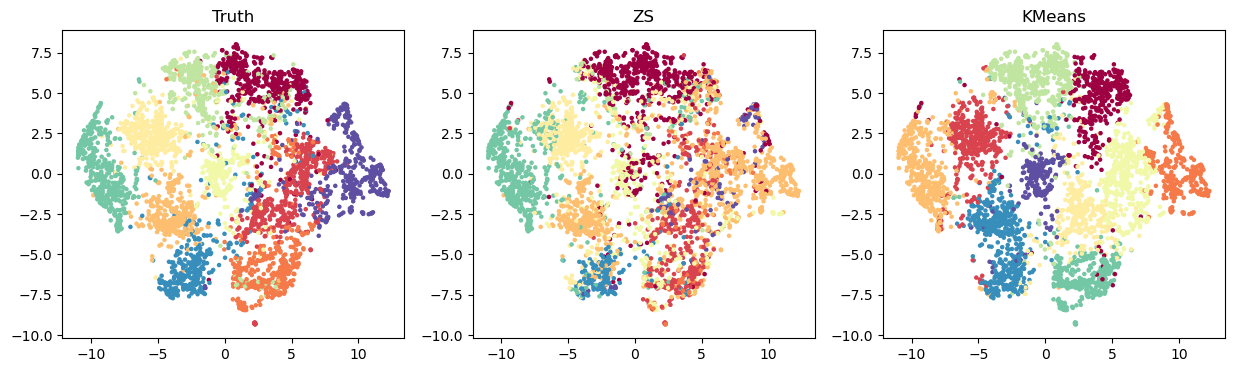

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax.ravel()

filepath = "output/ZeroshotCLIP_ETran/vit_b16"
dname = "eurosat"
K = 10
img_features = np.load(os.path.join(filepath, dname, "features.npy"))
labels = np.load(os.path.join(filepath, dname, "labels.npy"))
logits = np.load(os.path.join(filepath, dname, "logits.npy"))

preds = []
for logit in logits:
    preds.append(np.argmax(logit))
preds = np.array(preds)

sample_size = 4000  # Define the number of points to sample
indices = np.random.choice(img_features.shape[0], sample_size, replace=False)
img_features = img_features[indices]
labels = labels[indices]
logits = logits[indices]
preds = preds[indices]

kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(img_features)
labels_kmeans = kmeans.labels_

img_features_concat = np.concatenate((img_features, kmeans.cluster_centers_))

tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embedding = tsne_model.fit_transform(img_features_concat)

embedding_img = embedding[:-K]

cluster_centers = embedding[-K:]

# Plot the UMAP embedding
#plt.figure(figsize=(5, 3))
ax[0].scatter(embedding_img[:, 0], embedding_img[:, 1], s=5, cmap='Spectral', c=labels)
ax[1].scatter(embedding_img[:, 0], embedding_img[:, 1], s=5, cmap='Spectral', c=preds)
ax[2].scatter(embedding_img[:, 0], embedding_img[:, 1], s=5, cmap='Spectral', c=labels_kmeans)

ax[0].set_title("Truth")
ax[1].set_title("ZS")
ax[2].set_title("KMeans")
plt.show()


[3 8 8 8 8 8 3 3 8 3 8 8 8 8 8 3 8 6 8 8]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
[0 0 6 0 0 0 5 6 6 0 0 0 0 0 5 6 0 6 6 6]
[8 0 0 0 0 0 0 0 5 5 0 0 0 0 0 0 0 0 5 0]
[4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


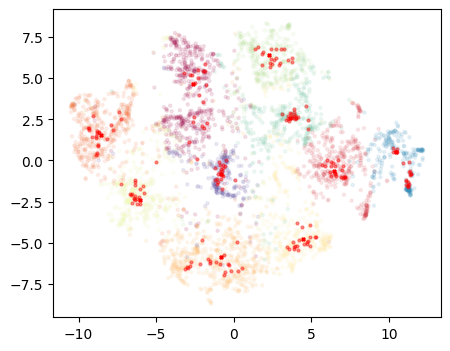

In [20]:
# Plot the UMAP embedding
plt.figure(figsize=(5, 4))
#plt.scatter(embedding_img[:, 0], embedding_img[:, 1], s=2, cmap='Spectral', c=labels)

plt.scatter(embedding_img[:, 0], embedding_img[:, 1], s=5, cmap='Spectral', c=labels_kmeans, alpha=0.1)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=5, c="red" ,marker="X")

distance = pairwise_distances(kmeans.cluster_centers_, img_features)
sample_idx = []
for d in distance:
    d_minid = np.argsort(d)
    d_minid = d_minid[:20]
    print(labels[d_minid])
    sample_idx.extend(d_minid)
    
sample_idx = np.array(list(set(sample_idx)))

img_features_cut = img_features[sample_idx]
logits_cut = logits[sample_idx]
labels_cut = labels[sample_idx]
embedding_img_cut = embedding_img[sample_idx]

plt.scatter(embedding_img_cut[:, 0], embedding_img_cut[:, 1], s=5, alpha=0.4, c="red", marker="H")
#plt.colorbar()
#plt.title('UMAP Projection of (8100, 512) Features')
#plt.xlabel('UMAP Dimension 1')
#plt.ylabel('UMAP Dimension 2')
plt.show()


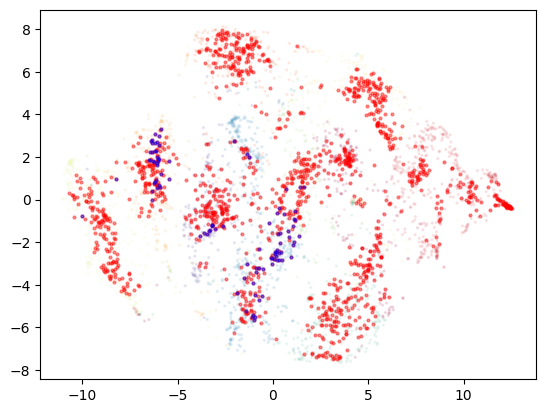

In [71]:
from scipy.stats import entropy as e

entropies = []
for l in logits_cut:
    entropies.append(e(l))
entropies = np.array(entropies)

#entropies = entropies[sample_idx]

entropies_sort_ids = np.argsort(entropies)#[::-1]
#entropies_sort_ids = entropies_sort_ids[:50]

plt.scatter(embedding_img[:, 0], embedding_img[:, 1], s=2, cmap='Spectral', c=labels_kmeans, alpha=0.1)

for idx in entropies_sort_ids:
    plt.scatter(embedding_img_cut[idx, 0], embedding_img_cut[idx, 1], s=5, alpha=0.4, c="red", marker="H")
for idx in entropies_sort_ids[:100]:
    plt.scatter(embedding_img_cut[idx, 0], embedding_img_cut[idx, 1], s=5, alpha=0.4, c="blue", marker="H")
#plt.scatter(embedding_img[sample_idx, 0], embedding_img[sample_idx, 1], s=5, alpha=0.4, c="red", marker="H")


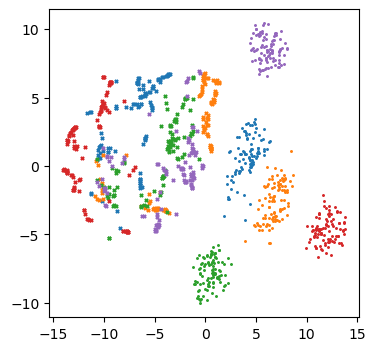

In [7]:
path = "output/base2new/train_base/eurosat/shots_1/OneShot_Adapter/vit_b16/seed1"
n_class = 5

with open(os.path.join(path, "txt_features_before_train.pkl"), "rb") as file:
    txt_features= pickle.load(file)

with open(os.path.join(path, "img_features_before_train.pkl"), "rb") as file:
    img_features= pickle.load(file)


txt_features = txt_features.reshape(-1, 512)
txt_features = txt_features.detach().cpu().numpy()

img_features = img_features.detach().cpu().numpy()

union_features = np.concatenate([img_features, txt_features])

tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embedding = tsne_model.fit_transform(union_features)

embedding_img = embedding[:len(img_features)]
embedding_txt = embedding[-len(txt_features):]

embedding_img = embedding_img.reshape(n_class, -1, 2)
embedding_txt = embedding_txt.reshape(n_class, -1, 2)

assert embedding_txt.shape[0] == embedding_img.shape[0]

# Plot the UMAP embedding
fig, ax = plt.subplots(figsize=(4, 4))

cmap = plt.get_cmap('tab10')
for idx, (ifs, tfs) in enumerate(zip(embedding_img, embedding_txt)):
    color = cmap(idx)
    ax.scatter(ifs[:, 0], ifs[:, 1], s=5, color=color, marker="x")
    ax.scatter(tfs[:, 0], tfs[:, 1], s=5, color=color, marker=".")

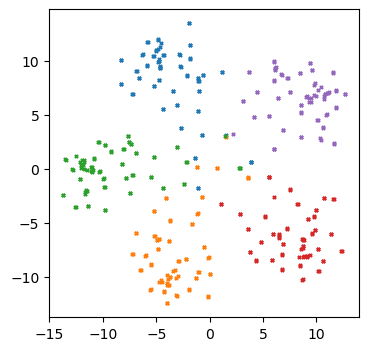

In [64]:
import os
import torch
import pickle
from trainers.imagenet_templates import IMAGENET_TEMPLATES

path = "output/base2new/train_base/eurosat/shots_1/OneShot_Adapter/vit_b16/seed1"
n_class = 5
template = IMAGENET_TEMPLATES

with open(os.path.join(path, "text_features_template.pkl"), "rb") as file:
    txt_features_template= pickle.load(file)

#txt_features_template = torch.cat(txt_features_template)
txt_features_template = txt_features_template.reshape(-1, 512)
txt_features_template = txt_features_template.detach().cpu().numpy()

tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embedding = tsne_model.fit_transform(txt_features_template)
embedding = embedding.reshape(len(template)+1, -1, 2)
# Plot the UMAP embedding
fig, ax = plt.subplots(figsize=(4, 4))

cmap = plt.get_cmap('tab10')
for idx, ifs in enumerate(embedding):
    idx = 0
    for f in ifs:
        color = cmap(idx)
        ax.scatter(f[0], f[1], s=5, color=color, marker="x")
        idx += 1


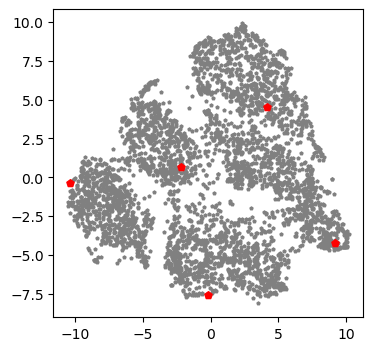

In [11]:
path = "output/base2new/train_base/eurosat/shots_1/OneShot_Adapter_Diverse/vit_b16/seed4"
n_class = 5

with open(os.path.join(path, "img_features_before_train.pkl"), "rb") as file:
    img_features= pickle.load(file)

with open(os.path.join(path, "embeddings_test_data.pkl"), "rb") as file:
    img_features_test= pickle.load(file)

with open(os.path.join(path, "img_features_before_aug.pkl"), "rb") as file:
    img_features_before_aug= pickle.load(file)


img_features_test = img_features_test.reshape(-1, 512)

img_features_before_aug = img_features_before_aug.detach().cpu().numpy()
img_features = img_features.detach().cpu().numpy()
img_features_test = img_features_test.detach().cpu().numpy()

union_features = np.concatenate([img_features_before_aug, img_features_test])
#union_features = np.concatenate([img_features_before_aug, img_features_test])
#union_features = np.concatenate([img_features_before_aug, img_features])

tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
embedding = tsne_model.fit_transform(union_features)

# embedding_img = embedding[:len(img_features)]
# embedding_test = embedding[-len(img_features_test):]

# embedding_img = embedding_img.reshape(n_class, -1, 2)
# embedding_test = embedding_test.reshape(n_class, -1, 2)

# # Plot the UMAP embedding
fig, ax = plt.subplots(figsize=(4, 4))

cmap = plt.get_cmap('tab10')
# for idx, (ifs, tfs) in enumerate(zip(embedding_img, embedding_test)):
#     color = cmap(idx)
#     ax.scatter(tfs[:, 0], tfs[:, 1], s=5, color=color, marker="x")
#     ax.scatter(ifs[:, 0], ifs[:, 1], s=50, color="gray", marker="p")

for idx, ifs in enumerate(embedding):
    if idx in range(0,5):
        ax.scatter(ifs[0], ifs[1], s=30, color="red", marker="p", zorder=2)
    ax.scatter(ifs[0], ifs[1], s=5, color="gray", marker="p")



In [9]:
img_features_before_aug.shape

(5, 512)

ValueError: Invalid RGBA argument: 0

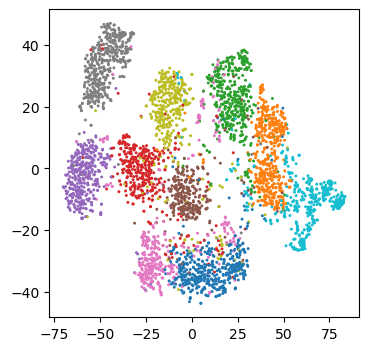

In [5]:
import random
import numpy as np

dataset = "eurosat"

path = f"output/base2new/train_base/{dataset}/shots_1/CoOp/vit_b16/seed1"
path_16 = f"output/base2new/train_base/{dataset}/shots_16/CoOp/vit_b16/seed1"
n_class = 10
n_class_max = 10
VISUAL_MAX_NUM = 4000

def scaling(data):
    min_val = np.min(data, axis=0, keepdims=True)
    max_val = np.max(data, axis=0, keepdims=True)
    return (data - min_val) / (max_val - min_val)

with open(os.path.join(path, "txt_features_before_training.pkl"), "rb") as file:
    txt_features_before_training= pickle.load(file)

with open(os.path.join(path, "txt_features_after_training.pkl"), "rb") as file:
    txt_features_1shot= pickle.load(file)

with open(os.path.join(path_16, "txt_features_after_training.pkl"), "rb") as file:
    txt_features_16shot= pickle.load(file)

with open(os.path.join(path, "img_features.pkl"), "rb") as file:
    img_features= pickle.load(file)

with open(os.path.join(path, "img_labels.pkl"), "rb") as file:
    img_labels= pickle.load(file)

img_features = np.concatenate(img_features)
img_labels = np.concatenate(img_labels)
txt_labels = np.array(range(n_class))

if len(img_features) > VISUAL_MAX_NUM:
    sample_idx = random.sample(range(len(img_features)), VISUAL_MAX_NUM)
    sample_idx = np.load("sample_idx_eurosat.npy")
    img_features = img_features[sample_idx]
    img_labels = img_labels[sample_idx]

txt_features_1shot = txt_features_1shot[0]
txt_features_16shot = txt_features_16shot[0]

img_features = scaling(img_features)
txt_features_1shot = scaling(txt_features_1shot)
txt_features_16shot = scaling(txt_features_16shot)

# ラベルが多い場合は10まで減らす
#target_labels = random.sample(range(n_class), n_class_max)
#target_labels = [2, 34, 1, 11, 4, 15, 36, 13, 21, 31, 10, 2, 23, 26, 34, 14, 35, 7, 3, 28]
#target_indices_img = np.where(np.isin(img_labels, target_labels))[0]
#target_indices_txt = np.where(np.isin(txt_labels, target_labels))[0]

# 指定のラベルの特徴量のみに絞る
# img_labels = img_labels[target_indices_img]
# img_features = img_features[target_indices_img]
# txt_labels = txt_labels[target_indices_txt]
# txt_features_1shot = txt_features_1shot[target_indices_txt]
# txt_features_16shot = txt_features_16shot[target_indices_txt]

# # ラベルを0~10に変換
# mapping = {d: i for i, d in enumerate(np.unique(img_labels))}
# relabel = np.vectorize(lambda x: mapping[x])

# img_labels = relabel(img_labels)
# txt_labels = relabel(txt_labels)

union_features = np.concatenate([img_features, txt_features_1shot, txt_features_16shot])
 
tsne_model = TSNE(n_components=2, random_state=42)
embedding = tsne_model.fit_transform(union_features)

# 各特徴量の長さを計算
len_img = len(img_features)
len_1shot = len(txt_features_1shot)
len_16shot = len(txt_features_16shot)
#len_before_training = len(txt_features_before_training)

# 各特徴量のembeddingを取り出すインデックスを計算
start_1shot = len_img
end_1shot = start_1shot + len_1shot

start_16shot = end_1shot
end_16shot = start_16shot + len_16shot

start_before_training = end_16shot
#end_before_training = start_before_training + len_before_training

# 各特徴量のembeddingを取り出す
embedding_img = embedding[:len_img]
embedding_txt_1shot = embedding[start_1shot:end_1shot]
embedding_txt_16shot = embedding[start_16shot:]
#embedding_txt_before_training = embedding[start_before_training:end_before_training]


# Plot the UMAP embedding
#fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(embedding_img[:, 0], embedding_img[:, 1], s=5, cmap='tab10', c=img_labels, marker=".")
# ax.scatter(embedding_txt_before_training[:, 0], embedding_txt_before_training[:, 1], s=400, cmap='tab10', 
#            c=txt_labels, marker="*", linewidth=1, edgecolors="black", linestyle=":", alpha=0.8)

ax.scatter(embedding_txt_1shot[:, 0], embedding_txt_1shot[:, 1], s=200, cmap='tab10', c="black", 
           marker="*", edgecolors=txt_labels, linewidth=0.8, alpha=0.8, linestyle=":")
ax.scatter(embedding_txt_16shot[:, 0], embedding_txt_16shot[:, 1], s=200, cmap='tab10', c=txt_labels, 
           marker="*", edgecolors="black", linewidth=0.8, alpha=0.8, linestyle="-")

plt.savefig("tsne.png", dpi=300)
# for i, text in enumerate(n_class):
#     ax.text(embedding_txt_16shot[i, 0], embedding_txt_16shot[i, 1], text)